In [1]:
## Imports
import numpy as np
import torch
from tabulate import tabulate
import pandas as pd
import random
from PIL import Image
import heapq
import json
import tqdm
from sortedcontainers import SortedList
from torch.utils.data import DataLoader
from utils.factory import create_model_and_transforms, get_tokenizer
from utils.visualization import image_grid, visualization_preprocess
from prs_hook import hook_prs_logger
from matplotlib import pyplot as plt
from utils.imagenet_classes import imagenet_classes
from compute_complete_text_set import svd_data_approx
from utils.dataset_helpers import dataset_to_dataloader
from torchvision.datasets import ImageNet


/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [115]:
## Hyperparameters

device = 'cpu'
pretrained = 'laion2b_s34b_b79k' # 'laion2b_s32b_b79k'
model_name = 'ViT-B-32' # 'ViT-H-14'
seed = 42
dataset_text_name = "top_1500_nouns_5_sentences_clean"
datataset_image_name = "imagenet"
algorithm = "svd_data_approx"
batch_size = 16 # only needed for the nn search
imagenet_path = './datasets/imagenet/' # only needed for the nn search

In [116]:
## Loading Model

model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained)
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))

prs = hook_prs_logger(model, device, spatial=False) # This attach hook to get the residual stream

Using local files
Model parameters: 151,277,313
Context length: 77
Vocab size: 49408
Len of res: 12


In [117]:
## Run algorithm on a dataset to derive eigenvectors 
command = f"python compute_complete_text_set.py --device {device} --model {model_name} --algorithm {algorithm} --seed {seed} --num_of_last_layers 4 --text_descriptions {dataset_text_name}"
!{command}

/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Number of layers: 12
  0%|                                                     | 0/4 [00:00<?, ?it/s]
Layer [8], Head: 0

Layer [8], Head: 1

Layer [8], Head: 2

Layer [8], Head: 3

Layer [8], Head: 4

Layer [8], Head: 5

Layer [8], Head: 6

Layer [8], Head: 7

Layer [8], Head: 8

Layer [8], Head: 9

Layer [8], Head: 10

Layer [8], Head: 11
 25%|███████████▎                                 | 1/4 [00:04<00:12,  4.18s/it]
Layer [9], Head: 0

Layer [9], Head: 1

Layer [9], Head: 2

Layer [9], Head: 3

Layer [9], Head: 4

Layer [9], Head: 5

Layer [9], Head: 6

Layer [9], Head: 7

Layer [9], Head: 8

Layer [9], Head: 9

Layer [9], Head: 10

Layer [9], Head: 11
 50%|██████████████████████▌              

In [118]:
# Load the new created attention datasets
attention_dataset = f"output_dir/{datataset_image_name}_completeness_{dataset_text_name}_{model_name}_algo_{algorithm}_seed_{seed}.jsonl"

# Strongest Contributions per Dataset

In [119]:
# Number of top entries to retrieve
top_k = 40
min_heap = []
# Read JSON lines
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)  # Parse each line as a JSON object

        if entry["head"] == -1: # Skip the last entry
            continue
        # Analyze each eigenvector    
        for i, eigenvector_data in enumerate(entry["embeddings_sort"]):
            strength_abs = eigenvector_data["strength_abs"]
            if len(min_heap) < top_k:
                heapq.heappush(min_heap, (strength_abs, i, entry))
            else:
                heapq.heappushpop(min_heap, (strength_abs, i, entry))

        
# Extract relevant details from the top k entries
top_k_entries = sorted(min_heap, key=lambda x: x[0], reverse=True)

top_k_details = [{
    "layer": entry["layer"],
    "head": entry["head"],
    "eigenvector": i,
    "strength_abs": entry["embeddings_sort"][i]["strength_abs"],
    "texts": entry["embeddings_sort"][i]["text"]
} for _, i, entry in top_k_entries]

# Display the results
top_k_df = pd.DataFrame(top_k_details)

for row in top_k_df.itertuples():
    output_rows = []
    texts = row.texts
    half_length = len(texts) // 2
    
    # Check if the first half is positive
    is_positive_first = list(texts[0].values())[1] > 0
    
    # Split into positive and negative based on the order
    positive_texts = texts[:half_length]
    negative_texts = texts[half_length:]
    
    for pos, neg in zip(positive_texts, negative_texts):
        pos_text = list(pos.values())[0]
        pos_val  = list(pos.values())[1]
        neg_text = list(neg.values())[0]
        neg_val  = list(neg.values())[1]    
        
        output_rows.append([pos_text, pos_val, neg_text, neg_val])

    print(f"Layer {row.layer}, Head {row.head}, Eigenvector {row.eigenvector}, Strength {row.strength_abs}")
    # Create a DataFrame for the output
    if is_positive_first:
        columns = ["Positive", "Positive_Strength", "Negative", "Negative_Strength"]    
    else:
        columns = ["Negative", "Negative_Strength", "Positive", "Positive_Strength"]    
    output_df = pd.DataFrame(output_rows, columns=columns)

    print(tabulate(output_df, headers='keys', tablefmt='psql'))


Layer 11, Head 7, Eigenvector 0, Strength 4.590941429138184
+----+-------------------------------------------------------------------+---------------------+------------------------------------------------------+---------------------+
|    | Negative                                                          |   Negative_Strength | Positive                                             |   Positive_Strength |
|----+-------------------------------------------------------------------+---------------------+------------------------------------------------------+---------------------|
|  0 | An image of a person petting a dog.                               |          -0.235667  | An image of white grains on a dark surface.          |           0.10539   |
|  1 | An image of a pet with its owner.                                 |          -0.178212  | An image of a sliced apple showing two equal halves. |           0.0935808 |
|  2 | An image of a person with their pet.                           

# Query a topic

In [134]:
# Number of top entries to retrieve
top_k = 10
text_query = "An image of a round object"
strength_min = 0.1 # Skip 
threshold_strength = 0.30

# Evaluate clip embedding for the given text
text_query_token = tokenizer(text_query).to(device)  # tokenize
topic_emb = model.encode_text(text_query_token)
topic_emb /= topic_emb.norm(dim=-1, keepdim=True)  # normalize

top_entries = SortedList()
# Read JSON lines
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)  # Parse each line as a JSON object

        if entry["head"] == -1:  # Skip the final embedding entry
            continue
        # Get necessary reconstruction data
        mean_text = torch.tensor(entry["mean_values_text"])
        vh = torch.tensor(entry["vh"])
        project_matrix = torch.tensor(entry["project_matrix"])

        # Get projection of text on the head
        topic_emb_proj = (topic_emb - mean_text) @ vh.T
        # Analyze each eigenvectors 
        for i, eigenvector_data in enumerate(entry["embeddings_sort"]):

            # Get absolute strn of the eigenvector
            text_corr = topic_emb_proj[:, i].squeeze()

            # Evaluate correlatcolorsion as the maximum value
            corr_sign = text_corr > 0
            correlation_value = torch.abs(text_corr).item()
            # Retrieve the top entries score of the database (both positive and negative)
            sign_order = list(eigenvector_data["text"][0].values())[1] > 0
            v_first =  list(eigenvector_data["text"][0].values())[1]
            v_second = list(eigenvector_data["text"][len(eigenvector_data["text"])//2].values())[1]
            v_pos = v_first if sign_order else v_second
            v_neg = v_first if not sign_order else v_second
            
            # Derive a relative score
            score = torch.max((text_corr - v_pos)/np.abs(v_pos), (-text_corr + v_neg)/np.abs(v_neg)).item()
            # Discard too low coorelation
            if eigenvector_data["strength_abs"]*correlation_value < strength_min or \
            (text_corr/v_pos < threshold_strength if corr_sign else text_corr/v_neg <  threshold_strength):
                continue
            top_entries.add((score, (i, corr_sign, eigenvector_data["strength_abs"]*correlation_value, entry)))

            if len(top_entries) > top_k:
                top_entries.pop(0)  # Remove the smallest correlation

# Extract relevant details from the top k entries
top_k_entries = list(top_entries)[::-1]  # Reverse to have largest first
top_k_details = []
for (score, (i, corr_sign, correlation, entry)) in top_k_entries:
    texts = entry["embeddings_sort"][i]["text"]
    length = len(texts) // 2
    first_text_pos = (list(entry["embeddings_sort"][i]["text"][0].values())[1] > 0)
    # Sort texts based on the correlation sign
    texts = sorted(texts[:length], key=lambda x: list(x.values())[1], reverse= first_text_pos) + \
            sorted(texts[length:], key=lambda x: list(x.values())[1], reverse= not first_text_pos)

        
    top_k_details.append({
        "layer": entry["layer"],
        "head": entry["head"],
        "eigenvector": i,
        "eigenvector_strength": entry["embeddings_sort"][i]["strength_abs"],
        "correlation": correlation/entry["embeddings_sort"][i]["strength_abs"] if corr_sign else -correlation/entry["embeddings_sort"][i]["strength_abs"],
        "strength": correlation if corr_sign else -correlation,
        "texts": texts
    })

top_k_df = pd.DataFrame(top_k_details)
# Display the results
for row in top_k_df.itertuples():
    output_rows = []
    # Show the correlation of each eigenvector already multiplied by the strength of the right singular value
    texts = [{k: (v * row.eigenvector_strength if i == 1 else v) for i, (k, v) in enumerate(d.items())} for d in row.texts]
    half_length = len(texts) // 2
    # Check if the first half is positive
    is_positive_corr = row.correlation > 0
    is_positive_first = list(texts[0].values())[1] > 0

    # Create a DataFrame for the output
    if is_positive_corr:
        columns = ["Positive", "Positive_Strength", "Negative", "Negative_Strength"] 
        first = texts[:half_length] if is_positive_first else texts[half_length:]
        second = texts[half_length:] if is_positive_first else texts[:half_length] 
    else:
        columns = ["Negative", "Negative_Strength", "Positive", "Positive_Strength"]   
        first = texts[half_length:] if is_positive_first else texts[:half_length]
        second = texts[:half_length] if is_positive_first else texts[half_length:]
        
    for pos, neg in zip(first, second):
        pos_text = list(pos.values())[0]
        pos_val  = list(pos.values())[1]
        neg_text = list(neg.values())[0]
        neg_val  = list(neg.values())[1]    
        
        output_rows.append([pos_text, pos_val, neg_text, neg_val])

    print(f"Layer {row.layer}, Head {row.head}, Eigenvector {row.eigenvector}, Eigenvector Strength {row.eigenvector_strength}, Correlation {row.correlation}, Strength {row.strength}")    
     
    output_df = pd.DataFrame(output_rows, columns=columns)


    print(tabulate(output_df, headers='keys', tablefmt='psql'))


Layer 11, Head 11, Eigenvector 10, Eigenvector Strength 1.385765790939331, Correlation -0.11626331508159637, Strength -0.16111372478127706
+----+----------------------------------------------------------------+---------------------+----------------------------------------------------------------------------+---------------------+
|    | Negative                                                       |   Negative_Strength | Positive                                                                   |   Positive_Strength |
|----+----------------------------------------------------------------+---------------------+----------------------------------------------------------------------------+---------------------|
|  0 | An image of a round ball with red stitches.                    |           -0.208815 | An image of dried fruits with wrinkled skin laid out on a table.           |            0.213312 |
|  1 | An image of a weightlifter lifting an extremely heavy barbell. |           -0.2075

# Test accuracy of reconstruction using only basis

In [8]:
# Number of top entries to retrieve
top_k = 20
min_heap = []

# Prepare both text and image for the query

# Image
image = preprocess(Image.open('images/woman.png'))[np.newaxis, :, :, :]
## Run the image:
prs.reinit() # Reinitialize the residual stream hook
with torch.no_grad():
    image_emb = model.encode_image(image.to(device), 
                                        attn_method='head_no_spatial', 
                                        normalize=True)


# Text
text_query = "A beautiful woman."
text_query_token = tokenizer(text_query).to(device)  # tokenize
topic_emb = model.encode_text(text_query_token, normalize=True) 

# Reconstructions
image_emb_rec = torch.zeros_like(topic_emb)
topic_emb_rec = torch.zeros_like(topic_emb)
# Read JSON lines
with open(attention_dataset, "r") as json_file:
    for line in json_file:

        
        entry = json.loads(line)  # Parse each line as a JSON object
        if entry["head"] == -1:  # Skip the final embedding entry
            last_line = entry
            continue

        project_matrix = torch.tensor(entry["project_matrix"])
        vh = torch.tensor(entry["vh"])
        # Get projection of text on the head
        topic_emb_rec += (topic_emb - torch.tensor(entry["mean_values_text"])) @ vh.T @ project_matrix @ vh + torch.tensor(entry["mean_values_text"])
        image_emb_rec += (image_emb - torch.tensor(entry["mean_values_att"])) @ vh.T @ project_matrix @ vh + torch.tensor(entry["mean_values_att"])

print(topic_emb_rec.norm()) 
print(image_emb_rec.norm())
topic_emb_rec /= topic_emb_rec.norm(dim=-1, keepdim=True)  # normalize
image_emb_rec /= image_emb_rec.norm(dim=-1, keepdim=True)  # normalize  
print(topic_emb @ topic_emb_rec.T)
print(image_emb @ image_emb_rec.T)

print(topic_emb @ image_emb.T)
print(topic_emb @ image_emb_rec.T)
print(topic_emb_rec @ image_emb.T)
print(topic_emb_rec @ image_emb_rec.T)

tensor(35.3541, grad_fn=<LinalgVectorNormBackward0>)
tensor(10.6186)
tensor([[0.8530]], grad_fn=<MmBackward0>)
tensor([[0.8454]])
tensor([[0.2579]], grad_fn=<MmBackward0>)
tensor([[0.1799]], grad_fn=<MmBackward0>)
tensor([[0.2091]], grad_fn=<MmBackward0>)
tensor([[0.1413]], grad_fn=<MmBackward0>)


# NNs on eigenvectors

In [ ]:
# Where we want to project at
data = \
{
    "layer": 11,
    "head": 11,
    "eigenvector": 10,
}

# Optional text to find value at some strength in the eigenvector
text_pres = True
text_query = text_query
text_query_token = tokenizer(text_query).to(device)  # tokenize
text_emb = model.encode_text(text_query_token, normalize=True) 

In [124]:
## Create the pool for the nn search from same dataset
ds = ImageNet(root=imagenet_path, split="val", transform=preprocess) # For running the model
ds_vis = ImageNet(root=imagenet_path, split="val", transform=visualization_preprocess) # For showing images

# Take subset of dataset
samples_per_class=1
tot_samples_per_class=50
random.seed(40)
all_indices = list(range(len(ds)))
nr_classes = len(ds.classes)
index = [random.sample(all_indices[x*tot_samples_per_class:(x + 1)*tot_samples_per_class], samples_per_class) for x in range(nr_classes)]
index = [x for xs in index for x in xs]
dataset = torch.utils.data.Subset(ds, index)
ds_vis = torch.utils.data.Subset(ds_vis, index)
# Get subset datasets on demand:
dataloader = DataLoader(
            dataset, batch_size=batch_size, shuffle=False, num_workers=8
        )

# Get wanted vh matrix
with open(attention_dataset, "r") as json_file:
    for line in json_file:
        entry = json.loads(line)  # Parse each line as a JSON object

        # Keep looking until right head and layer is found
        if entry["layer"] != data["layer"] or entry["head"] != data["head"]:
            continue
        
        # Get vh matrix from 
        vh = torch.tensor(entry["vh"])
        mean_values_att = torch.tensor(entry["mean_values_att"])
        mean_values_text = torch.tensor(entry["mean_values_text"])  
        eigenvector_strength = entry["embeddings_sort"][data["eigenvector"]]["strength_abs"]
        break

if text_pres:
    text_repres = ((text_emb - mean_values_text) @ vh.T)[:, data["eigenvector"]].squeeze()

### Optional

In [125]:
# Preprocess dataset to already have all images

### Test 

In [126]:
# Initialize array store the top and worst scores for each search head
scores_array = np.empty(len(ds)//tot_samples_per_class*samples_per_class, dtype=[('score', 'f4'), ('img_index', 'i4')])
# Go over the dataset and calculate scores for each search head
for index, (images, labels) in tqdm.tqdm(enumerate(dataloader), total=len(dataloader)):
    images = images.to(device)
    with torch.no_grad():
        prs.reinit() # Reinitialize the residual stream hook
        current_representation = model.encode_image(images, attn_method='head_no_spatial', normalize=True)
        # Project to right values space
        current_representation = (current_representation - mean_values_att) @ vh.T
        # Score contribution for fixed eigenvector
        scores = current_representation[:, data["eigenvector"]]
        # Query to find most similar contributions
        scores = scores
        # Update top and worst scores for the current search head
        for i in range(min(batch_size, images.shape[0])):
            scores_array[batch_size * index + i] = (scores[i].item(), batch_size * index + i) 


100%|██████████| 63/63 [00:28<00:00,  2.23it/s]


In [127]:
# Define the number of top and worst images to look at for each eigenvector
nr_top_imgs = 20  # Number of top elements
nr_worst_imgs = 20  # Number of worst elements
nr_cont_imgs = 20  # Length of continuous elements
nr_text_imgs = 20  # Length of most similar images

# Sort indices of scores
sorted_scores = np.sort(scores_array, order='score')
# Top scores
top_dbs = sorted_scores[-nr_top_imgs:][::-1]  # Get top `nr_top_imgs` elements, sorted descending
# Worst scores
worst_dbs = sorted_scores[:nr_worst_imgs]  # Get worst `nr_worst_imgs` elements, sorted ascending
# Continuous scores (step-based interpolation)
indices = np.linspace(0, len(sorted_scores) - 1, num=nr_cont_imgs, dtype=int)
cont_dbs = sorted_scores[indices]
# Similarity scores if given text
if text_pres:
    array = [(abs(score - text_repres.detach().cpu().numpy()), idx) for score, idx in sorted_scores]
    differences = np.array(array, dtype=[('score', 'f4'), ('img_index', 'i4')])
    sorted_differences = np.sort(differences, order='score')
    text_dbs = sorted_differences[:nr_text_imgs]  # Get top `nr_top_imgs` elements, sorted ascending
    

Layer 11, Head 2, Eigenvector 23
+----+--------------------------------------------------------+---------------------+---------------------------------------------------------+---------------------+
|    | Positive                                               |   Positive_Strength | Negative                                                |   Negative_Strength |
|----+--------------------------------------------------------+---------------------+---------------------------------------------------------+---------------------|
|  0 | An image of a sunset with orange and pink hues.        |            0.19147  | An image of a woman with a loving expression.           |           -0.144278 |
|  1 | An image of orange and yellow colors.                  |            0.187217 | An image of a nurse.                                    |           -0.134265 |
|  2 | An image of a shiny metallic body.                     |            0.181079 | An image of a nurse giving a patient medicine.     

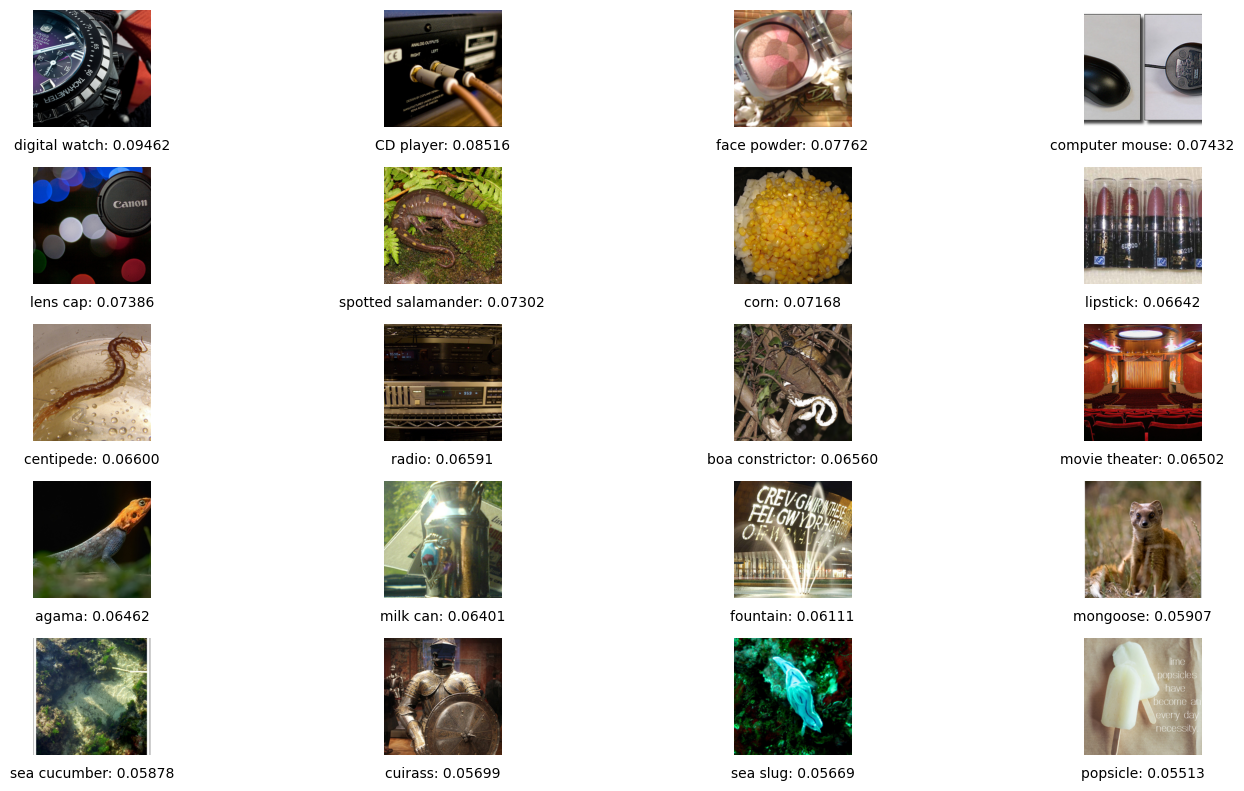

Printing most negative directions


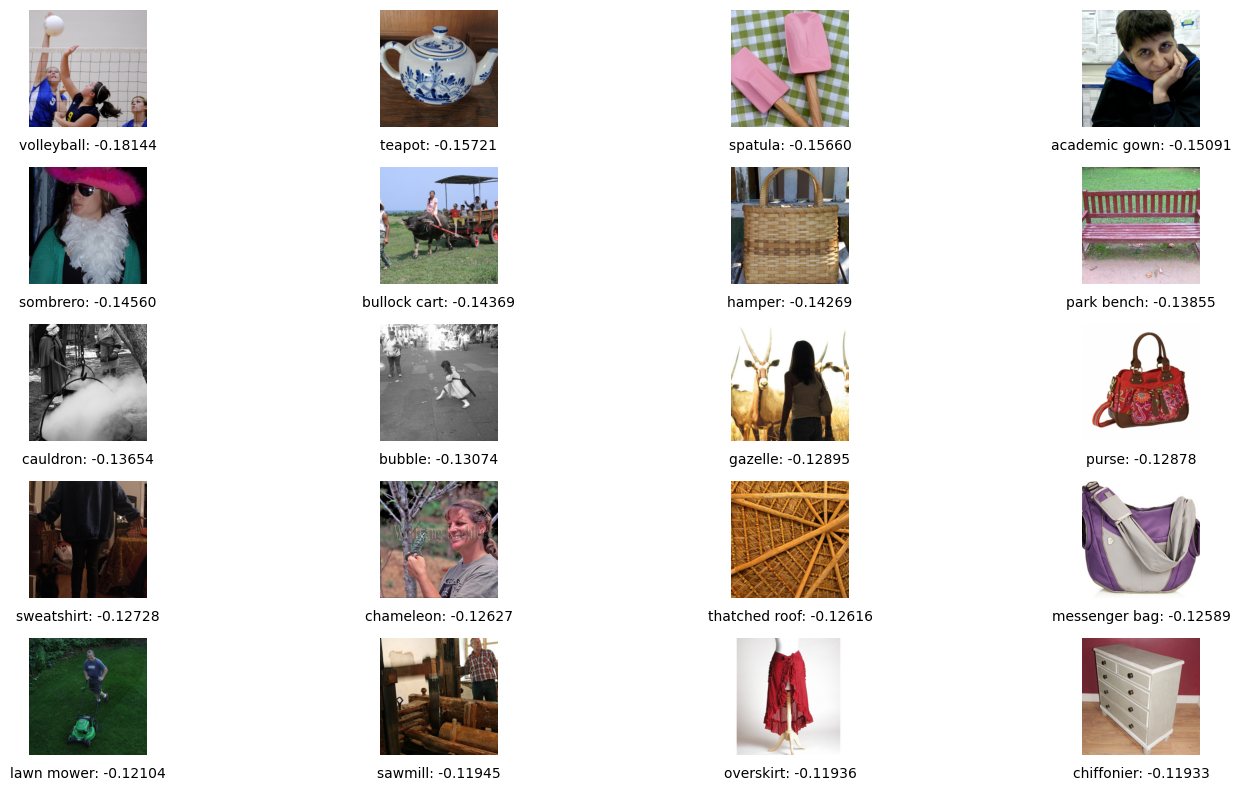

Printing continous directions


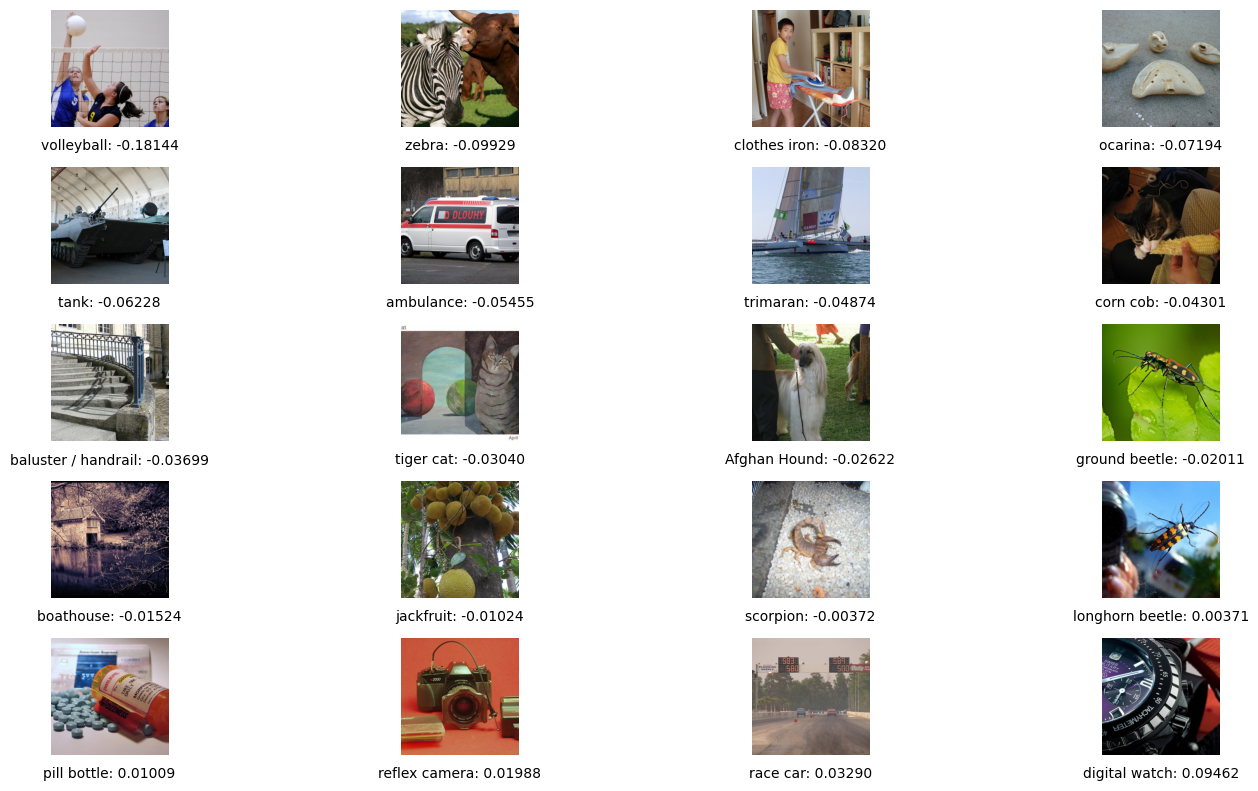

Printing most similar directions to text: 'An image of a woman' with score -0.10822314769029617


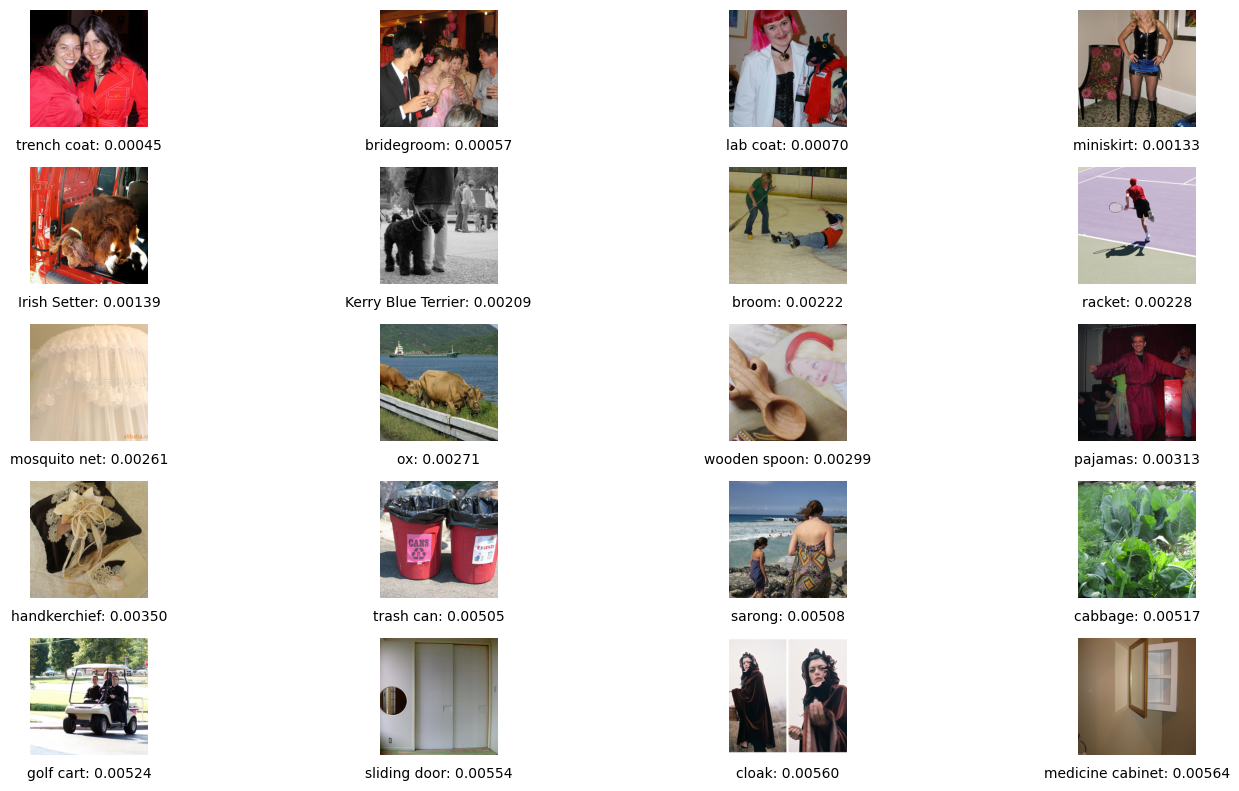

In [128]:
# Print info eigenvectors
output_rows = []
texts = entry["embeddings_sort"][data["eigenvector"]]["text"]
half_length = len(texts) // 2

# Check if the first half is positive
is_positive_first = list(texts[0].values())[1] > 0

# Split into positive and negative based on the order
positive_texts = texts[:half_length]
negative_texts = texts[half_length:]

for pos, neg in zip(positive_texts, negative_texts):
    pos_text = list(pos.values())[0]
    pos_val  = list(pos.values())[1]
    neg_text = list(neg.values())[0]
    neg_val  = list(neg.values())[1]    
    
    output_rows.append([pos_text, pos_val, neg_text, neg_val])

print(f"Layer {entry["layer"]}, Head {entry["head"]}, Eigenvector {data["eigenvector"]}")
# Create a DataFrame for the output
if is_positive_first:
    columns = ["Positive", "Positive_Strength", "Negative", "Negative_Strength"]    
else:
    columns = ["Negative", "Negative_Strength", "Positive", "Positive_Strength"]    
output_df = pd.DataFrame(output_rows, columns=columns)

print(tabulate(output_df, headers='keys', tablefmt='psql'))


# Show images
dbs = [(top_dbs, "Printing most positive directions"), \
       (worst_dbs, "Printing most negative directions"), \
       (cont_dbs, "Printing continous directions")]
if text_pres:
    dbs.append((text_dbs, f"Printing most similar directions to text: '{text_query}' with score {text_repres}"))
for db, text in dbs:
    # Example usage: Display top and worst images for 
    images, labels, scores = [], [], []
    for score, image_index in db:
        images.append(ds_vis[image_index][0])
        labels.append(imagenet_classes[ds_vis[image_index][1]])
        scores.append(score)
    print(text)
    image_grid(images, 5, 4, labels=labels, scores=scores)
    

